<img src="http://imgur.com/1ZcRyrc.png" style="float: left; margin: 20px; height: 85px">

# Capstone Project 

# COVID-19 classification based on Chest CT Scan

by: Lin Junyuan DSI-14

## Problem Statement

To develop a Convolutional Neural Network-based classification model, based on Chest CT Scan data in the axial view, to determine whether COVID-19 infection is present, with a targeted performance of 80% for both accuracy and sensitivity.

## Executive Summary

The novel coronavirus 2019 (COVID-2019) was first detected in Wuhan, China during the end of December 2019. Rapidly, it spread throughout the world and was classified as a pandemic within months. It was highly disruptive, driving cities and states into lockdowns in a bid to contain its spread. The global economy, lives and livelihoods of millions were adversely affected.

During the early phases, early detection and containment were proven to be highly effective counter-measures. However, being a novel coronavirus, test kits were not readily available. Detection was key and many countries around the world prioritise testing and were actively building up their capabilities in this respect.

Radiological imaging techniques, such as chest CT scans has been found to contain discernable effects of a COVID-19 infection. In these scans, Ground Glass opacities (GGOs) show up in infected patients' scans and expands as the disease's severity increases. Hence, this project proposes to apply Artificial Intelligence (AI) techniques, namely convolutional neural network (CNN) to detect COVID-19. If successful, this technology can be applied to serve as an auxiliary diagnostic tool, or further expanded to trace and track disease severity.

Based on the amount of data available (May 2020), our [model](#Selected-Model) was able to attain an accuracy of 0.83, a sensitivity of 0.95 and AUC ROC score of 0.87.

## Sections

- [Import libraries](#Import-libraries)
- [Dataset source information](#Dataset-source-information)
- [Dataset summary](#Dataset-summary)
- [Pre-processing](#Pre-processing)
- [Load metadata](#Load-metadata)
- [Data preparation](#Data-preparation)
    - [Train-test-split](#Train-test-split)
    - [Augment non-Covid data in df_train](#Augment-non-Covid-data-in-df_train)
    - [Augment non-Covid data in df_test](#Augment-non-Covid-data-in-df_test)
- [Modelling](#Modelling)
    - [Fine tuning](#Fine-tuning)
    - [Model Evaluation and Selection](#Model-Evaluation-and-Selection)
- [Selected Model](#Selected-Model)
- [Conclusion and Recommendations](#Conclusion-and-Recommendations)
- [References](#References)

### Import libraries

In [107]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import cv2 as cv
import os
import datetime

from sklearn.model_selection import GroupShuffleSplit
from sklearn.metrics import confusion_matrix, roc_auc_score

import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, GlobalMaxPooling2D
from tensorflow.keras.initializers import Constant
from tensorflow.keras import utils
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, Callback, EarlyStopping

%matplotlib inline

In [2]:
%load_ext tensorboard

In [3]:
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  1


## Dataset source information

Source 1: `Kaggle\COVID-19 CT scans` [Link](https://www.kaggle.com/andrewmvd/covid19-ct-scans)
- 20 sets of images in `.nii` file format 
- 20 patients who are diagnosed as COVID-19 positive
- 6 `.jpg` images from each `.nii` file
- Total: 120 COVID-19 positive images

Source 2: `GitHub\UCSD-AI4H\COVID-CT` [Link](https://github.com/UCSD-AI4H/COVID-CT)
- 346 images in `.png` file format of COVID-19 positive scans
- 216 patients who are diagnosed as COVID-19 positive
- 397 images in `.jpg`, `.png` file formats of COVID-19 negative scans
- 171 patients who are diagnosed as COVID-19 negative

Source 3: `GitHub\ieee8023\covid-chestxray-dataset` [Link](https://github.com/ieee8023/covid-chestxray-dataset)
- 43 images in `.jpeg`, `.jpg`, `.png` file format of COVID-19 positive scans
- 23 patients who are diagnosed as COVID-19 positive
- 4 images in `.jpeg`, `.jpg` file format of COVID-19 negative scans
- 3 patients who are diagnosed as COVID-19 negative

Source 4: `Toy Dataset synthesized from actual patient scans from Covid19Challenge.eu` [Link](https://www.covid19challenge.eu/covid-19-toy-datasets-released/)
- 96 sets of images in `.nii` file format 
- 6 `.jpg` images from each `.nii` file
- Total: 576 COVID-19 positive images

Source 5: `Scraped CT images from Radiopaedia.org` [Link](https://radiopaedia.org/)
- 72 images in `.jpeg`, `.jpg` file format of COVID-19 negative scans
- 12 patients who are diagnosed as COVID-19 negative

Source 6: `MosMedData: COVID19_1000 Dataset` [Link](https://mosmed.ai/en/)
- 254 sets of images in `.nii` file format
- 254 patients who are diagnosed as COVID-19 positive
- 6 `.jpg` images from each `.nii` file
- Total: 1524 COVID-19 negative images
- 856 sets of images in `.nii` file format 
- 856 patients who are diagnosed as COVID-19 positive
- 6 `.jpg` images from each `.nii` file
- Total: 5076 COVID-19 positive images

### Dataset summary

In [6]:
num_covid_imgs = (20*6)+346+43+(96*6)+(856*6)
print(f"Number of Covid positive images: {num_covid_imgs}")

num_noncovid_imgs = 397+4+72+(254*6)
print(f"Number of Covid negative images: {num_noncovid_imgs}")

print('=========================================')
num_imgs_total = num_covid_imgs + num_noncovid_imgs
print(f"Total number of images: {num_imgs_total}")
print('=========================================')
num_covid_patients = 20 + 216 + 23 + 96 + 856
print(f"Number of Covid positive patients: {num_covid_patients}")

num_noncovid_patients = 171 + 3 + 12 + 254
print(f"Number of Covid negative patients: {num_noncovid_patients}")
print('=========================================')
num_patients_total = num_covid_patients + num_noncovid_patients
print(f"Total number of patients: {num_patients_total}")
print('=========================================')

Number of Covid positive images: 6221
Number of Covid negative images: 1997
Total number of images: 8218
Number of Covid positive patients: 1211
Number of Covid negative patients: 440
Total number of patients: 1651


## Pre-processing

As the data comes in a variety of formats and resolutions, the preprocessing was performed in a seperate `preprocessing.py` file located in the `code` folder. The preprocessing workflow can generally be described in the following steps:

1. Load image from `source` folder
    - If source file is a `.nii` 3D image file, 6 slices will be retrieved from each file
2. Perform median blurring to remove noise
    <img src="./assets/median.jpg" alt="median denoising" width="128" height="128" float="left">
3. Perform adaptive histogram equalization
    <img src="./assets/img_cl.jpg" alt="CLAHE" width="128" height="128">
4. Apply thresholding to get binary image
    <img src="./assets/thresh.jpg" alt="threshold" width="128" height="128">
5. Eliminate background
    <img src="./assets/thresh2.jpg" alt="background removed" width="128" height="128">
6. Perform dilation
7. Perform contour detection to mark out the lung area
    <img src="./assets/contours.jpg" alt="contours" width="128" height="128">
8. Use contours to mark out a rectangular region around the lungs
    <img src="./assets/bounding_region.jpg" alt="bounding region" width="128" height="128">
9. Crop image based on rectangular region
10. Resize cropped image into desired dimensions (224, 280)
11. Save preprocessed image into `data` folder

A `metadata.csv` file recording each preprocessed image's filename, filepath, patientID (Retrieved or generated) and if the image is Covid positive or negative.

## Load metadata

In [7]:
metadata = pd.read_csv('./metadata.csv')

In [8]:
metadata.head()

,filename,patientID,isCovid,filepath
0,S1_coronacases_org_001_1.jpg,S1_1,1,.\data\CT_Covid\S1_coronacases_org_001_1.jpg
1,S1_coronacases_org_001_2.jpg,S1_1,1,.\data\CT_Covid\S1_coronacases_org_001_2.jpg
2,S1_coronacases_org_001_3.jpg,S1_1,1,.\data\CT_Covid\S1_coronacases_org_001_3.jpg
3,S1_coronacases_org_001_4.jpg,S1_1,1,.\data\CT_Covid\S1_coronacases_org_001_4.jpg
4,S1_coronacases_org_001_5.jpg,S1_1,1,.\data\CT_Covid\S1_coronacases_org_001_5.jpg


In [9]:
metadata['isCovid'].value_counts()

1    6221
0    1997
Name: isCovid, dtype: int64

In [10]:
metadata['isCovid'].value_counts(normalize=True)

1    0.756997
0    0.243003
Name: isCovid, dtype: float64

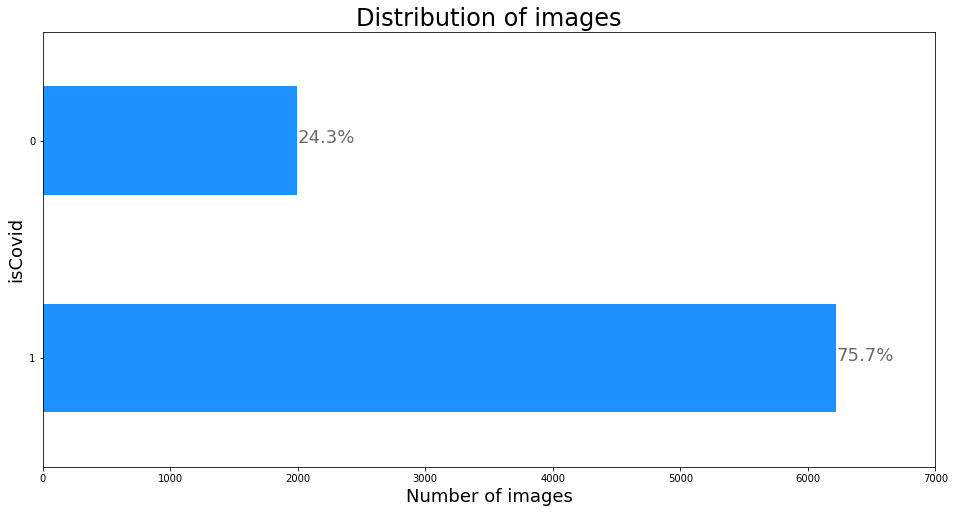

In [11]:
plt.figure(figsize=(16,8))
ax = metadata['isCovid'].value_counts().plot(kind='barh', color = 'dodgerblue')
plt.xlabel('Number of images',fontsize=18)
plt.xlim((0,7000))
plt.ylabel('isCovid',fontsize=18)
plt.title('Distribution of images',fontsize=24);

totals = []
for i in ax.patches:
    totals.append(i.get_width())

total = sum(totals)
for i in ax.patches:
    # get_width pulls left or right; get_y pushes up or down
    ax.text(i.get_width()+.1, i.get_y()+.24, \
            str(round((i.get_width()/total)*100, 2))+'%', fontsize=18,
color='dimgrey')

**Comment**

There is data imbalance with 3 times as much Covid positive data as non-Covid data. Augmentation needs to be performed on the non-Covid data to balance out the distribution.

However, prior to that, consideration must be given to the fact that there are multiple images from the same patient. These images are likely to be highly correlated to each other. Therefore, in order to prevent data leakage, the `patientID` column will be considered when performing train-test-split.

Data augmentation will be performed after the split so that augmented data will not cause data leakage.

## Data preparation

## Train-test-split

In [12]:
train_inds, test_inds = next(GroupShuffleSplit(test_size=.20, n_splits=2).split(metadata, groups=metadata['patientID']))

In [13]:
df_train = metadata.iloc[train_inds]
df_test = metadata.iloc[test_inds]

In [14]:
df_train['isCovid'].value_counts(normalize=True)

1    0.758942
0    0.241058
Name: isCovid, dtype: float64

In [15]:
df_test['isCovid'].value_counts(normalize=True)

1    0.749403
0    0.250597
Name: isCovid, dtype: float64

### Augment non-Covid data in df_train

In [16]:
# Create ImageDataGenerator and define parameters
img_datagen = ImageDataGenerator(width_shift_range=0.05,
                                 height_shift_range=0.05,
                                 horizontal_flip=True,
                                 fill_mode='nearest',
                                 brightness_range=[0.8,1.2])

In [17]:
# Create randomly generated images for train
train_image_gen = img_datagen.flow_from_dataframe(dataframe= df_train[df_train['isCovid']==0],
                                                  directory= '.',
                                                  x_col= 'filepath',
                                                  y_col= 'isCovid',
                                                  class_mode= 'raw',
                                                  color_mode='grayscale',
                                                  target_size= (224,280),
                                                  batch_size = 1,
                                                  save_to_dir='.\\data\\CT_nonCovid\\aug_train',
                                                  save_prefix='aug',
                                                  save_format='jpeg')

num_images = df_train['isCovid'].value_counts()[1] - df_train['isCovid'].value_counts()[0]

Found 1577 validated image filenames.


In [18]:
on = False

if on:
    i = 0
    for batch in train_image_gen:
        i+=1
        if i == num_images:
            break

In [19]:
# Generate dataframe of newly created images and add to df_train
aug_train_patient_list = []
aug_train_filenames = []
aug_train_filepaths = []
aug_train_isCovid = []

for root, _, files in os.walk('.\\data\\CT_nonCovid\\aug_train'):
    for file in files:
        aug_train_filenames.append(file)
        aug_train_filepaths.append(os.path.join(root,file))
        aug_train_patient_list.append('aug_train')
        aug_train_isCovid.append(0)
        
df_aug_train = pd.DataFrame({'filename': aug_train_filenames, 
                             'patientID': aug_train_patient_list,
                             'isCovid': aug_train_isCovid, 
                             'filepath': aug_train_filepaths})

df_train_bal = pd.concat([df_train,df_aug_train])

In [20]:
# Verify that data is now balanced
df_train_bal['isCovid'].value_counts(normalize=True)

1    0.503294
0    0.496706
Name: isCovid, dtype: float64

### Augment non-Covid data in df_test

In [21]:
# Create randomly generated images for test
test_image_gen = img_datagen.flow_from_dataframe(dataframe= df_test[df_test['isCovid']==0],
                                                  directory= '.',
                                                  x_col= 'filepath',
                                                  y_col= 'isCovid',
                                                  class_mode= 'raw',
                                                  color_mode='grayscale',
                                                  target_size= (224,280),
                                                  batch_size = 1,
                                                  save_to_dir='.\\data\\CT_nonCovid\\aug_test',
                                                  save_prefix='aug',
                                                  save_format='jpeg')

num_images = df_test['isCovid'].value_counts()[1] - df_test['isCovid'].value_counts()[0]

Found 420 validated image filenames.


In [22]:
on = False

if on:
    i = 0
    for batch in test_image_gen:
        i+=1
        if i == num_images:
            break

In [23]:
# Generate dataframe of newly created images and add to df_test
aug_test_patient_list = []
aug_test_filenames = []
aug_test_filepaths = []
aug_test_isCovid = []

for root, _, files in os.walk('.\\data\\CT_nonCovid\\aug_test'):
    for file in files:
        aug_test_filenames.append(file)
        aug_test_filepaths.append(os.path.join(root,file))
        aug_test_patient_list.append('aug_test')
        aug_test_isCovid.append(0)
        
df_aug_test = pd.DataFrame({'filename': aug_test_filenames, 
                             'patientID': aug_test_patient_list,
                             'isCovid': aug_test_isCovid, 
                             'filepath': aug_test_filepaths})

df_test_bal = pd.concat([df_test,df_aug_test])

In [24]:
# Verify that data is now balanced
df_test_bal['isCovid'].value_counts(normalize=True)

0    0.512612
1    0.487388
Name: isCovid, dtype: float64

In [25]:
# Generate X_train, X_test, y_train, y_test
train_filenames_list = df_train_bal['filepath'].tolist()
train_labels_list = df_train_bal['isCovid'].astype('int32').tolist()

test_filenames_list = df_test_bal['filepath'].tolist()
test_labels_list = df_test_bal['isCovid'].astype('int32').tolist()

X_train = np.asarray([cv.cvtColor(cv.imread(filename), cv.COLOR_BGR2GRAY) for filename in train_filenames_list])
y_train = np.asarray(train_labels_list)

X_test = np.asarray([cv.cvtColor(cv.imread(filename), cv.COLOR_BGR2GRAY) for filename in test_filenames_list])
y_test = np.asarray(test_labels_list)

In [26]:
# Normalise X (images)
X_train = X_train.astype('float32') / 255
X_test = X_test.astype('float32') / 255

In [27]:
# Reshape X to fit model
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], X_train.shape[2], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], X_test.shape[2], 1)

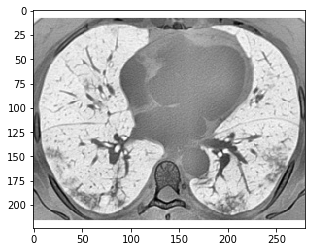

In [28]:
plt.imshow(X_train[0].reshape(224,280), cmap= plt.cm.gray_r);

---

##  Modelling

In [29]:
def create_model(model_name, layers_list):
    model = Sequential(name = model_name)
    
    for layer in layers_list:
        if layer[0] == 'input':
            model.add(Conv2D(filters= layer[1],
                             kernel_size= layer[2],
                             activation= 'relu',    
                             input_shape= (224,280,1)
                             ))
        if layer[0] == 'conv':
            model.add(Conv2D(filters= layer[1],
                             kernel_size= layer[2],
                             activation= 'relu'
                            ))
        if layer[0] == 'maxpool':
            model.add(MaxPooling2D(pool_size=(layer[1],layer[1])))
        if layer[0] == 'dropout':
            model.add(Dropout(layer[1]))
        if layer[0] == 'gblAvgPool':
            model.add(GlobalAveragePooling2D())
        if layer[0] == 'dense':
            model.add(Dense(layer[1], activation='relu'))
    
    model.add(Dense(1, activation= 'sigmoid'))
        
    model.compile(loss='binary_crossentropy',
                      optimizer='adam',
                      metrics=['accuracy'])
    
    return model

In [30]:
def run_models(models):
    df_results = pd.DataFrame(columns=['model_name', 'true_negative', 'false_positive', 'false_negative', 'true_positive'])
    for model_name, values in models.items():
        model = create_model(model_name, values['layers_list'])
    #     model.summary()

        # Define callbacks
        checkpoint = ModelCheckpoint("./checkpoints/{0}_{{epoch:02d}}_{{val_accuracy:.2f}}.hdf5".format(model_name),
                                     verbose=1, 
                                     save_best_only=True, 
                                     mode='auto')

        early_stop = EarlyStopping(monitor='val_loss', min_delta=0.03, patience=3, mode='auto',verbose=1)

        log_dir = "logs/fit/" + model_name + "_" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
        tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

        history = model.fit(x= X_train,
                            y= y_train,
                            batch_size = 32,
                            validation_data= (X_test, y_test),
                            epochs=values['epochs'],
                            callbacks=[checkpoint, tensorboard_callback, early_stop],
                            verbose=1)

        preds = (model.predict(X_test) > 0.5).astype('int32')

        tn, fp, fn, tp = confusion_matrix(y_test,preds).reshape(-1)

        df_results.loc[len(df_results)] = [model_name, tn, fp, fn, tp]

        model.save(f'./models/{model_name}.h5')

        tf.keras.backend.clear_session()
        
        # Read results from previous session
        df_result_save = pd.read_csv('results.csv')
        df_result_save = pd.concat([df_result_save, df_results])
        df_result_save.to_csv('results.csv', index=False)
    

---

![Initial model](./assets/initial_model.png)

**Comment**

After a series of empirical testing, the above model is found to be performing reasonably well. Fine tuning will be done to optimise the hyperparameters.

### Fine tuning

**Round 1**

For the first round, the number of filters in each layer will be varied.
    - Model1_1: same as initial model
    - Model1_2: halve the number of filters
    - Model1_3: double the number of filters

In [31]:
models1 = {'model1_1': {'layers_list' : [['input', 32, 3],
                                        ['conv', 64, 3],
                                        ['maxpool', 2],
                                        ['dropout', 0.25],
                                        ['conv', 32, 3],
                                        ['maxpool', 2],
                                        ['gblAvgPool'],
                                        ['dense', 256],
                                        ['dense', 128],
                                        ['dropout', 0.5],
                                        ['dense', 64]],
                     'epochs': 10
                    },
          'model1_2': {'layers_list' : [['input', 16, 3],
                                        ['conv', 32, 3],
                                        ['maxpool', 2],
                                        ['dropout', 0.25],
                                        ['conv', 16, 3],
                                        ['maxpool', 2],
                                        ['gblAvgPool'],
                                        ['dense', 128],
                                        ['dense', 64],
                                        ['dropout', 0.5],
                                        ['dense', 32]],
                     'epochs': 10
                    },
          'model1_3': {'layers_list' : [['input', 64, 3],
                                        ['conv', 128, 3],
                                        ['maxpool', 2],
                                        ['dropout', 0.25],
                                        ['conv', 64, 3],
                                        ['maxpool', 2],
                                        ['gblAvgPool'],
                                        ['dense', 512],
                                        ['dense', 256],
                                        ['dropout', 0.5],
                                        ['dense', 128]],
                     'epochs': 10
                    }
                    }

In [ ]:
on = False

if on:
    run_models(models1)

**Round 2**

For the second round, the size of the kernels in each layer will be varied.
    - Model2_1: same as initial model
    - Model2_2: kernel size changed to 5
    - Model2_3: kernel size changed to 7

In [45]:
models2 = {'model2_1': {'layers_list' : [['input', 32, 3],
                                        ['conv', 64, 3],
                                        ['maxpool', 2],
                                        ['dropout', 0.25],
                                        ['conv', 32, 3],
                                        ['maxpool', 2],
                                        ['gblAvgPool'],
                                        ['dense', 256],
                                        ['dense', 128],
                                        ['dropout', 0.5],
                                        ['dense', 64]],
                     'epochs': 10
                    },
          'model2_2': {'layers_list' : [['input', 32, 5],
                                        ['conv', 64, 5],
                                        ['maxpool', 2],
                                        ['dropout', 0.25],
                                        ['conv', 32, 5],
                                        ['maxpool', 2],
                                        ['gblAvgPool'],
                                        ['dense', 256],
                                        ['dense', 128],
                                        ['dropout', 0.5],
                                        ['dense', 64]],
                     'epochs': 10
                    },
          'model2_3': {'layers_list' : [['input', 32, 7],
                                        ['conv', 64, 7],
                                        ['maxpool', 2],
                                        ['dropout', 0.25],
                                        ['conv', 32, 7],
                                        ['maxpool', 2],
                                        ['gblAvgPool'],
                                        ['dense', 256],
                                        ['dense', 128],
                                        ['dropout', 0.5],
                                        ['dense', 64]],
                     'epochs': 10
                    }
                    }

In [54]:
on = False

if on:
    run_models(models2)

**Round 3**

For the final round, the number of layers will be varied.
    - Model3_1: same as initial model
    - Model3_2: removed one conv layer and one dense layer
    - Model3_3: added one conv layer and one dense layer

In [45]:
models3 = {'model3_1': {'layers_list' : [['input', 32, 3],
                                        ['conv', 64, 3],
                                        ['maxpool', 2],
                                        ['dropout', 0.25],
                                        ['conv', 32, 3],
                                        ['maxpool', 2],
                                        ['gblAvgPool'],
                                        ['dense', 256],
                                        ['dense', 128],
                                        ['dropout', 0.5],
                                        ['dense', 64]],
                     'epochs': 10
                    },
          'model3_2': {'layers_list' : [['input', 32, 3],
                                        ['maxpool', 2],
                                        ['dropout', 0.25],
                                        ['conv', 32, 3],
                                        ['maxpool', 2],
                                        ['gblAvgPool'],
                                        ['dense', 256],
                                        ['dropout', 0.5],
                                        ['dense', 128]],
                     'epochs': 10
                    },
          'model3_3': {'layers_list' : [['input', 32, 3],
                                        ['conv', 64, 3],
                                        ['maxpool', 2],
                                        ['dropout', 0.25],
                                        ['conv', 32, 3],
                                        ['conv', 32, 3],
                                        ['maxpool', 2],
                                        ['gblAvgPool'],
                                        ['dense', 256],
                                        ['dense', 128],
                                        ['dropout', 0.5],
                                        ['dense', 64],
                                        ['dense', 32]],
                     'epochs': 10
                    }
                    }

In [48]:
on = False

if on:
    run_models(models3)

### Model Evaluation and Selection

In [44]:
%tensorboard --logdir logs/fit --host localhost

Reusing TensorBoard on port 6006 (pid 13316), started 0:01:34 ago. (Use '!kill 13316' to kill it.)

In [121]:
df_result_save = pd.read_csv('results.csv')

df_result_save.sort_values('model_name',inplace=True)

In [122]:
def cal_metrics(df):
    df['accuracy'] = round((df['true_positive'] + df['true_negative'])/(df['true_positive'] + df['true_negative']+df['false_positive'] + df['false_negative']),2)
    df['sensitivity'] = round(df['true_positive']/(df['true_positive'] + df['false_negative']),2)
    df['specificity '] = round(df['true_negative']/(df['true_negative'] + df['false_positive']),2)

In [123]:
cal_metrics(df_result_save)
df_result_save

,model_name,true_negative,false_positive,false_negative,true_positive,accuracy,sensitivity,specificity
0,model1_1,1027,231,337,955,0.78,0.74,0.82
1,model1_2,866,392,74,1218,0.82,0.94,0.69
2,model1_3,947,311,105,1187,0.84,0.92,0.75
3,model2_1,896,395,63,1208,0.82,0.95,0.69
4,model2_2,853,438,32,1239,0.82,0.97,0.66
8,model2_3,917,404,50,1206,0.82,0.96,0.69
5,model3_1,920,321,135,1178,0.82,0.90,0.74
6,model3_2,941,300,173,1140,0.81,0.87,0.76
7,model3_3,1241,0,1313,0,0.49,0.00,1.00


**Evaluation**

Based on the results of the three rounds of testing, it is observed from round 1 that increasing the number of filters aid in improving accuracy. The results from round two indicated that increasing kernel size to 5 helps to reduce the number of false negatives significantly, hence enhancing its sensitivity score. Further increment to size 7 does not show even better results, however.


### Selected Model

![Selected model](./assets/selected_model.png)

**Comment**

From the evaluation results, the selected model will have double number of filters in each layer and kernel size increased to 5.

In [55]:
selected_model = {'model_selected': {'layers_list' : [['input', 64, 5],
                                                      ['conv', 128, 5],
                                                      ['maxpool', 2],
                                                      ['dropout', 0.25],
                                                      ['conv', 64, 5],
                                                      ['maxpool', 2],
                                                      ['gblAvgPool'],
                                                      ['dense', 512],
                                                      ['dense', 256],
                                                      ['dropout', 0.5],
                                                      ['dense', 128]],
                                     'epochs': 10
                                    }}

In [62]:
selected_model_name = list(selected_model.keys())[0]

In [63]:
final_model = create_model(selected_model_name, selected_model[selected_model_name]['layers_list'])

In [64]:
final_model.summary()

Model: "model_selected"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 220, 276, 64)      1664      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 216, 272, 128)     204928    
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 108, 136, 128)     0         
_________________________________________________________________
dropout (Dropout)            (None, 108, 136, 128)     0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 104, 132, 64)      204864    
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 52, 66, 64)        0         
_________________________________________________________________
global_average_pooling2d (Gl (None, 64)             

In [67]:
# Define callbacks
checkpoint = ModelCheckpoint("./checkpoints/{0}_{{epoch:02d}}_{{val_accuracy:.2f}}.hdf5".format(selected_model_name),
                             verbose=1, 
                             save_best_only=True, 
                             mode='auto')

early_stop = EarlyStopping(monitor='val_loss', min_delta=0.03, patience=3, mode='auto',verbose=1)

log_dir = "logs/fit/" + selected_model_name + "_" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

history = final_model.fit(x= X_train,
                          y= y_train,
                          batch_size = 32,
                          validation_data= (X_test, y_test),
                          epochs=selected_model[selected_model_name]['epochs'],
                          callbacks=[checkpoint, tensorboard_callback, early_stop],
                          verbose=1)

Epoch 1/10
309/309 [==============================] - ETA: 0s - loss: 0.6937 - accuracy: 0.4967
Epoch 00001: val_loss improved from inf to 0.69139, saving model to ./checkpoints/model_selected_01_0.59.hdf5
309/309 [==============================] - 208s 672ms/step - loss: 0.6937 - accuracy: 0.4967 - val_loss: 0.6914 - val_accuracy: 0.5933
Epoch 2/10
309/309 [==============================] - ETA: 0s - loss: 0.6804 - accuracy: 0.5714
Epoch 00002: val_loss improved from 0.69139 to 0.65902, saving model to ./checkpoints/model_selected_02_0.63.hdf5
309/309 [==============================] - 206s 668ms/step - loss: 0.6804 - accuracy: 0.5714 - val_loss: 0.6590 - val_accuracy: 0.6263
Epoch 3/10
309/309 [==============================] - ETA: 0s - loss: 0.5918 - accuracy: 0.6847
Epoch 00003: val_loss improved from 0.65902 to 0.50046, saving model to ./checkpoints/model_selected_03_0.76.hdf5
309/309 [==============================] - 206s 668ms/step - loss: 0.5918 - accuracy: 0.6847 - val_loss:

In [124]:
preds = (final_model.predict(X_test) > 0.5).astype('int32')

tn, fp, fn, tp = confusion_matrix(y_test,preds).reshape(-1)

df_result_save.loc[len(df_result_save)] = [selected_model_name, 
                                           tn, 
                                           fp, 
                                           fn, 
                                           tp, 
                                           round((tp+tn)/(tn+fp+fn+tp),2),
                                           round(tp/(tp+fn),2),
                                           round(tn/(tn+fp),2)]
df_result_save

,model_name,true_negative,false_positive,false_negative,true_positive,accuracy,sensitivity,specificity
0,model1_1,1027,231,337,955,0.78,0.74,0.82
1,model1_2,866,392,74,1218,0.82,0.94,0.69
2,model1_3,947,311,105,1187,0.84,0.92,0.75
3,model2_1,896,395,63,1208,0.82,0.95,0.69
4,model2_2,853,438,32,1239,0.82,0.97,0.66
8,model2_3,917,404,50,1206,0.82,0.96,0.69
5,model3_1,920,321,135,1178,0.82,0.90,0.74
6,model3_2,941,300,173,1140,0.81,0.87,0.76
7,model3_3,1241,0,1313,0,0.49,0.00,1.00
9,model_selected,947,374,61,1195,0.83,0.95,0.72


**Comment**

The selected model has performed better than the previous models, gaining the improvement in accuracy from the doubling of the number of filters, whilst having improved sensitivity score from increasing kernel size to 5.

In [105]:
df_final = pd.DataFrame({'y_true':list(y_test),
                         'pred_probs': list(final_model.predict(X_test))})

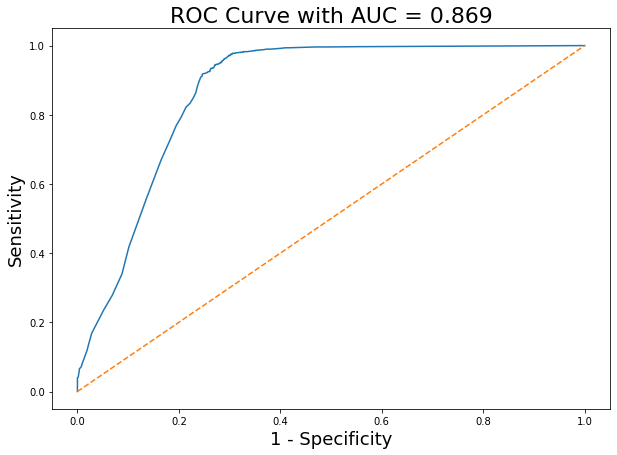

In [110]:
# Create figure.
plt.figure(figsize = (10,7))

# Create threshold values. (Dashed red line in image.)
thresholds = np.linspace(0, 1, 200)

# Define function to calculate sensitivity. (True positive rate.)
def TPR(df, true_col, pred_prob_col, threshold):
    true_positive = df[(df[true_col] == 1) & (df[pred_prob_col] >= threshold)].shape[0]
    false_negative = df[(df[true_col] == 1) & (df[pred_prob_col] < threshold)].shape[0]
    return true_positive / (true_positive + false_negative)


# Define function to calculate 1 - specificity. (False positive rate.)
def FPR(df, true_col, pred_prob_col, threshold):
    true_negative = df[(df[true_col] == 0) & (df[pred_prob_col] <= threshold)].shape[0]
    false_positive = df[(df[true_col] == 0) & (df[pred_prob_col] > threshold)].shape[0]
    return 1 - (true_negative / (true_negative + false_positive))

# Calculate sensitivity & 1-specificity for each threshold between 0 and 1.
tpr_values = [TPR(df_final, 'y_true', 'pred_probs', prob) for prob in thresholds]
fpr_values = [FPR(df_final, 'y_true', 'pred_probs', prob) for prob in thresholds]

# Plot ROC curve.
plt.plot(fpr_values, # False Positive Rate on X-axis
         tpr_values, # True Positive Rate on Y-axis
         label='ROC Curve')

# Plot baseline. (Perfect overlap between the two populations.)
plt.plot(np.linspace(0, 1, 200),
         np.linspace(0, 1, 200),
         label='baseline',
         linestyle='--')

# Label axes.
plt.title(f'ROC Curve with AUC = {round(roc_auc_score(df_final["y_true"],df_final["pred_probs"]),3)}', fontsize=22)

plt.ylabel('Sensitivity', fontsize=18)
plt.xlabel('1 - Specificity', fontsize=18);

In [114]:
final_model.save(f'./models/{selected_model_name}.h5')

---

## Conclusion and Recommendations

In conclusion, the selected model has an accuracy of 0.83, sensitivity of 0.95 and AUC ROC score of 0.87. The objective, as stated out in the problem statement, has been met.

During the course of this project, the lack of consistent and quality data was an impediment. However, there are multiple efforts globally to build up databases. As more data is gathered, subsequent refinement can be performed on this model to improve its performance further.

Based on some of the literature, the appearance of GGOs is not unique to COVID-19. With more data, a Multi-Class classification utilising the same CNN approach can be developed to order to differentiate between Covid infection and other types of viral/bacterial infection. There is also the possibility of exploring other methodologies such as Transfer Learning or CNNs utilising 3D CT Scan data (i.e. every slice from a .nii file).

##  References

- Lung Cancer Detection and Classification based on
Image Processing and Statistical Learning [Link](https://arxiv.org/pdf/1911.10654.pdf)
- GitHub\COVID-Net Open Source Initiative [Link](https://github.com/lindawangg/COVID-Net)
- Automated detection of COVID-19 cases using deep neural networks with X-ray images [Link](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC7187882/)
- Classification of COVID-19 patients from chest CT images using multi-objective differential evolution–based convolutional neural networks [Link](https://link.springer.com/article/10.1007/s10096-020-03901-z)
- Diagnosing COVID-19 Pneumonia from X-Ray and CT Images using Deep Learning and Transfer Learning Algorithms [Link](https://www.researchgate.net/publication/340374481_Diagnosing_COVID-19_Pneumonia_from_X-Ray_and_CT_Images_using_Deep_Learning_and_Transfer_Learning_Algorithms)